<a href="https://colab.research.google.com/github/Phoestia/Energy_Consumption_Prediction/blob/main/Energy_Cons_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task requirement

*   Leveraging the dataset: https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata
*   Build a model that predicts consumption
*   The electric consumption is located in the KWH field.

In [62]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedShuffleSplit, StratifiedKFold, learning_curve, train_test_split

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder,OrdinalEncoder
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV

from sklearn import model_selection
from sklearn import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Raw data

In [46]:
Survey_Data_path = 'https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv'
Survey_Data =  pd.read_csv(Survey_Data_path, sep=",")
Survey_Data.drop(columns=["DOEID"],inplace=True) # drop id

Survey_Data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,2,4,12,2,2471.68,4742,1080,4953,1271,4,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,4,10,26,2,8599.17,2662,199,2688,143,5,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,1,1,1,5,8969.92,6233,505,5741,829,1,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,2,3,7,2,18003.64,6034,672,5781,868,1,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,1,1,1,3,5999.61,5388,702,5313,797,1,...,-2,5A,2251,0,5426,0.61,4,50,13,90


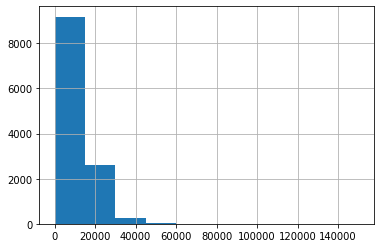

In [27]:
Survey_Data['KWH'].hist()

In [6]:
# quick missing value detection
Survey_Data.isnull().values.any()
Survey_Data.isnull().sum().sum()
# no missing value was found

0

In [28]:
# # load layout file
# Layout_file_path = 'https://www.eia.gov/consumption/residential/data/2009/csv/public_layout.csv'
# Layout_Data =  pd.read_csv(Layout_file_path, sep=",")
# Layout_Data.head()

In [52]:
# check correlation
def get_high_corr_df(df,positive_threshold=0.4):
  corr = df.corr().stack().reset_index().drop_duplicates()
  corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
  high_corr = corr[((corr['FEATURE_1'] != corr['FEATURE_2'] ) & (abs(corr['CORRELATION']) >= positive_threshold))]
  return high_corr

high_corr = get_high_corr_df(Survey_Data)
high_corr[((high_corr['FEATURE_1'] == 'KWH'))].sort_values(by = ['CORRELATION'],ascending=False)

,FEATURE_1,FEATURE_2,CORRELATION
100641,KWH,DOLLAREL,0.868712
100646,KWH,DOLELOTH,0.702251
100664,KWH,TOTALBTUOTH,0.676108
100670,KWH,TOTALDOLOTH,0.655742
100661,KWH,TOTALBTUCOL,0.655103
100663,KWH,TOTALBTURFG,0.638621
100665,KWH,TOTALDOL,0.627922
100667,KWH,TOTALDOLCOL,0.601628
100643,KWH,DOLELCOL,0.601626
100644,KWH,DOLELWTH,0.514613


In [53]:
high_corr.sort_values(by = ['CORRELATION'])

,FEATURE_1,FEATURE_2,CORRELATION
67319,DNTAC,AIRCOND,-0.992073
66981,AIRCOND,DNTAC,-0.992073
67375,DNTAC,ELCOOL,-0.992073
85965,ELCOOL,DNTAC,-0.992073
2383,HDD30YR,AIA_Zone,-0.946773
...,...,...,...
103364,CUFEETNGSPH,BTUNGSPH,1.000000
103024,CUFEETNG,BTUNG,1.000000
104376,BTUNG,CUFEETNG,1.000000
67036,AIRCOND,ELCOOL,1.000000


In [54]:
# drop high correlate columns 
# and imputation flags (start with "Z")
High_Cor_cols = [c for c in Survey_Data.columns if (("KWH" in c and len(c)>3) or "BTUEL" in c or c.startswith("Z"))]
Survey_Data.drop(columns=High_Cor_cols,inplace=True)

In [55]:
# drop columns with constant values
columns_with_constant_values = []
for c in Survey_Data.columns:
  value_frequencies = Survey_Data[c].value_counts(normalize=True)
  if value_frequencies.max()>=0.85:
    columns_with_constant_values.append(c)
print(len(columns_with_constant_values), " columns with constant values are dropped.")
print(columns_with_constant_values)
Survey_Data.drop(columns=columns_with_constant_values,inplace=True)

0  columns with constant values are dropped.
[]


In [56]:
# Check high corrlelated pairs
high_corr = get_high_corr_df(Survey_Data)
redundant_sets=[]
for i,row in high_corr[abs((high_corr['CORRELATION'])>=0.90)].iterrows():
  f1 = row['FEATURE_1']
  f2 = row['FEATURE_2']
  fset = {f1,f2}
  belongs_to_sets = []
  for j in range(len(redundant_sets)):
    if len(redundant_sets[j].intersection(fset))!=0:  
      belongs_to_sets.append(j)

  if len(belongs_to_sets)==0:
    redundant_sets.append(fset)
  elif len(belongs_to_sets)==1:
    redundant_sets[belongs_to_sets[0]].update(fset)
  else:
    sets_to_merge = [redundant_sets[j] for j in belongs_to_sets]
    for sm in sets_to_merge:
      redundant_sets.remove(sm)
      fset.update(sm)
    redundant_sets.append(fset)

for s in redundant_sets:
  print(s)

{'REGIONC', 'DIVISION', 'REPORTABLE_DOMAIN'}
{'NAPTFLRS', 'TYPEHUQ', 'STUDIO'}
{'HDD50', 'HDD65', 'GND_HDD65', 'HDD30YR'}
{'CDD30YR', 'CDD65'}
{'HUPROJ', 'KOWNRENT'}
{'YEARMADE', 'YEARMADERANGE'}
{'TOTROOMS', 'OTHROOMS'}
{'BASECOOL', 'BASEUSE', 'BASEFIN', 'BASEHEAT'}
{'ATTCCOOL', 'ATTICUSE', 'ATTCHEAT', 'ATTICFIN'}
{'GARGCOOL', 'GARGHEAT', 'SIZEOFGARAGE', 'GARGLOC'}
{'TYPECLN', 'OVENCLN'}
{'USEOTH', 'OUTGRILLFUEL'}
{'REFRIGT2', 'SIZRFRI2', 'TYPERFR2', 'MONRFRI2', 'NUMFRIG'}
{'SIZFREEZ', 'FREEZER', 'UPRTFRZR', 'NUMFREEZ', 'SEPFREEZ'}
{'RNSETEMP', 'DRYER', 'TOPFRONT', 'WASHLOAD', 'WASHTEMP', 'CWASHER', 'DRYRUSE'}
{'TVONWDWATCH1', 'TVONWEWATCH1'}
{'TVAUDIOSYS2', 'DIGITSTB2', 'TVSIZE2', 'TVTYPE2', 'DVD2', 'VCR2', 'OTHERSTB2', 'PLAYSTA2', 'COMBOVCRDVD2'}
{'TVONWE2', 'TVONWD2'}
{'TVAUDIOSYS3', 'VCR3', 'TVONWD3', 'CABLESAT3', 'TVTYPE3', 'DVD3', 'TVONWE3', 'DIGITSTB3', 'OTHERSTB3', 'PLAYSTA3', 'COMBOVCRDVD3', 'DVR3', 'TVSIZE3'}
{'INDSL', 'INCABLE', 'INDIALUP', 'INSATEL', 'INWIRELESS', 'PCONOFF

In [57]:
for s in redundant_sets:
  s.pop()
  Survey_Data.drop(columns=list(s),inplace=True)

### Train Test Spliting

In [58]:
columns = Survey_Data.columns.tolist()
y_cols = list(filter(lambda col: col != "KWH", columns))
X = Survey_Data[y_cols]
Y = Survey_Data['KWH']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True,
    random_state=1)

### Encode Features

In [59]:
str_cols = X_train.select_dtypes(include = 'object').columns

LE = LabelEncoder()
for col in str_cols:
  X_train[col] = LE.fit_transform(X_train[col].astype(str))
  

In [65]:
X_train.columns

Index(['REGIONC', 'NWEIGHT', 'CDD30YR', 'Climate_Region_Pub', 'AIA_Zone', 'UR',
       'YEARMADE', 'OCCUPYYRANGE', 'NUMFLRS', 'NUMAPTS',
       ...
       'PERIODEL', 'KAVALNG', 'IECC_Climate_Pub', 'HDD50', 'CDD80', 'WSF',
       'OA_LAT', 'GWT', 'DesignDBT99', 'DesignDBT1'],
      dtype='object', length=231)

### FE Testing 

In [69]:
for col in str_cols:
  X_test[col] = LE.fit_transform(X_test[col].astype(str))

### Build Model

In [70]:

estimators = [('lgbm', GradientBoostingRegressor(random_state=42,max_depth=5)),
              ('lr', LinearRegression()),
              ('rc', RidgeCV())]

stack = StackingRegressor(estimators=estimators[:-1],final_estimator=estimators[-1][1])
print("Individual resutls:")
for estimator in estimators:
  print("model: %s, score: %f" %(estimator[0],estimator[1].fit(X_train, y_train).score(X_test, y_test)))
  
print("################\nEnsemble result")
stack.fit(X_train, y_train).score(X_test, y_test)

Individual resutls:
model: lgbm, score: 0.972915
model: lr, score: 0.983777
model: rc, score: 0.983773
################
Ensemble result


0.9877420341599737